# Victor Vu Dask

For this project, we were given two datasets from Kaggle https://www.kaggle.com/marklvl/bike-sharing-dataset/home containing information about the Bike Sharing service in Washington D.C. "Capital Bikeshare"

One dataset contains hourly data and the other one has daily data from the years 2011 and 2012.

The following variables are included in the data:

* instant: Record index
* dteday: Date
* season: Season (1:springer, 2:summer, 3:fall, 4:winter)
* yr: Year (0: 2011, 1:2012)
* mnth: Month (1 to 12)
* hr: Hour (0 to 23, only available in the hourly dataset)
* holiday: whether day is holiday or not (extracted from Holiday Schedule)
* weekday: Day of the week
* workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered (Our target variable)

We are tasked with building a predictive model that can determine how many people will use the service on an hourly basis, therefore we take the first 5 quarters of the data for our training dataset and the last quarter of 2012 will be the holdout against which we perform our validation. Since that data was not used for training, we are sure that the evaluation metric that we get for it (R2 score) is an objective measurement of its predictive power.

### Planning

Initially, we decided to separate the project in 4 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Data Preparation and Feature Engineering: Once we have the data, we would need to prepare it for the modeling stage, standardizing it, changing data types, dropping features, among others. Later, a process of creating features and selecting others based on a number of different criteria like correlation, would also need to be performed.

Modeling and Tuning: Once we have the data ready, the modeling stage begins, making use of different models (and ensembles) and a strong pipeline with different transformers, we would hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned models, we would predict against the test set we decided to separate initially, then plotting those results against their actual values to determine the performance of the model, and finally, outlining our conclusions after this extensive project.


In [1]:
#! pip install dask-ml
#! pip install dask_xgboost


In [2]:
import warnings
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import seaborn as sns
import dask.array as da
import plotly.tools as tls
import plotly.plotly as py
from sklearn.base import clone
import plotly.graph_objs as go
import matplotlib.pyplot as plt

tls.set_credentials_file(username='alejandro321', api_key='yBVtyuhfWpl3rH4TrOGE')
warnings.filterwarnings('ignore')

In [3]:
SEED = 1
DATA_PATH = 'https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv'
DATA_PATH2 = 'https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv'
PREC_PATH = 'https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv'
TARGET_VARIABLE = 'cnt'
ESTIMATORS = 50

### Data Loading

Here we load the necessary data, print its first rows and describe its contents

In [4]:
def read_data(input_path):
    return dd.read_csv(input_path, parse_dates=[1])

data = read_data(DATA_PATH)
data_daily = read_data(DATA_PATH2)

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Precipitation Data

In order to generate our model, we will add precipitation data obtained from the National Climatic Data Center https://www.ncdc.noaa.gov/cdo-web/datasets

However, since most of the values are 0, we will convert them to a boolean that determines if rain was present or not at that specific hour

In [5]:
precipitation = read_data(PREC_PATH)
data = dd.merge(data, precipitation,  how='left', on=['dteday','hr'])
data = data.fillna(0)
data['precipitation'] = data['precipitation'].apply(lambda x: 1 if x > 0 else 0)
data['precipitation'] = data['precipitation'].astype('category')

data_hourly = data.copy()
data_hourly = data_hourly.loc[data_hourly["dteday"] < "2012-10-1"]

### Check for na 

In [6]:
data.isna().sum().compute()

instant          0
dteday           0
season           0
yr               0
mnth             0
hr               0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
precipitation    0
dtype: int64

### Converting columns to their true categorical type
Converting columns to their true categorical type
Now we convert the data types of numerical columns that are actually categorical

In [7]:
data[['season', 'yr','mnth','hr','holiday','weekday','workingday','weathersit']]= data[['season', 'yr','mnth','hr','holiday','weekday','workingday','weathersit']].astype('category')

In [8]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

### Check for missing data

In [9]:
data.isnull().sum().compute()

instant          0
dteday           0
season           0
yr               0
mnth             0
hr               0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
precipitation    0
dtype: int64

#### Add lag of registered users
In order to improve the long term prediction efficacy of our model we add lags of the number of users for the previous hour and the previous 24 hours

In [10]:
data['registered_1'] = data['registered'].shift(1)
data['registered_24'] = data['registered'].shift(24)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation,registered_1,registered_24
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,NaN,NaN
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,13.0,NaN
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1,32.0,NaN
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1,27.0,NaN
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,10.0,NaN


Since there will be no lag for the first few values, we will drop all the columns with NA in the registered. 

In [11]:
data =data.dropna(how = 'any')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation,registered_1,registered_24
24,25,2011-01-02,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,4,13,17,1,24.0,13.0
25,26,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,1,16,17,1,13.0,32.0
26,27,2011-01-02,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,1,8,9,1,16.0,27.0
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,2,4,6,1,8.0,10.0
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,2,1,3,1,4.0,1.0


### Dropping Column Casual and Registered

In [12]:
data = data.drop('casual',axis=1)
data = data.drop('registered',axis=1)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,precipitation,registered_1,registered_24
24,25,2011-01-02,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,17,1,24.0,13.0
25,26,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,17,1,13.0,32.0
26,27,2011-01-02,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,9,1,16.0,27.0
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,6,1,8.0,10.0
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,3,1,4.0,1.0


## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model

We must specify that **all of this analysis is performed only on the training data**, so that we do not incur in any sort of bias when modeling

To start we define some color palettes to be used

In [13]:
palette_tot_cas_reg = ['darkgreen', 'darkred', 'darkblue']

palette_cas = ['darkred', 'salmon']
palette_reg = ['darkblue', 'skyblue']

In [14]:
data_hist = [go.Histogram(x=data_hourly['cnt'])]

py.iplot(data_hist, filename='basic histogram', color = 'darkgreen')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~alejandro321/0 or inside your plot.ly account where it is named 'basic histogram'


### Temperature Vs. Windspeed

In [15]:
trace = go.Scatter(
    x = data_hourly['atemp'],
    y = data_hourly['windspeed'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='windspeed'
    ),
    xaxis=go.layout.XAxis(
        title='temperature'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='basic-scatter')

### Hourly Humidity Average

In [16]:
trace = go.Scatter(
    x = data_hourly['hr'],
    y = data_hourly['hum'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='humidity'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_hr_hum')

### Average Casual User Usage

In [17]:
trace = go.Scatter(
    x = data_hourly['hr'],
    y = data_hourly['cnt']-data_hourly['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='casual users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

### Average Registered User Usage

In [18]:
trace = go.Scatter(
    x = data_hourly['hr'],
    y = data_hourly['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='registered users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

### Usage over time, by type of user and total ( Jan 2011 - Oct 2012 )

<Figure size 864x576 with 0 Axes>

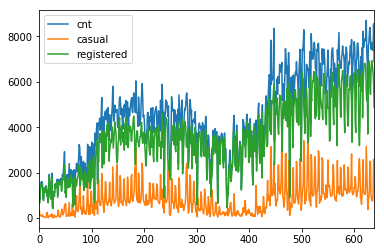

In [19]:
data_daily = data_daily.loc[data_daily["dteday"] < "2012-10-1"]
data_daily[['season', 'yr','mnth','holiday','weekday','workingday','weathersit']]= data_daily[['season', 'yr','mnth','holiday','weekday','workingday','weathersit']].astype('category')
plt.figure(figsize=(12,8))
data_daily[['cnt', 'casual','registered']].compute().plot()



They all seem to be increasing and have some seasonality. I have tried to build different graph, to analyse the the trend at smaller granularity (Monthly, Weekly, Daily, Hourly). However when I tried to group by cnt, casual and registered, the function does not accept multiple grouping. 

## Baseline

A basic linear model is created in order to set a baseline which further models will be compared against

In [20]:
Base_data = data.categorize().compute()
Base_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,precipitation,registered_1,registered_24
24,25,2011-01-02,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,17,1,24.0,13.0
25,26,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,17,1,13.0,32.0
26,27,2011-01-02,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,9,1,16.0,27.0
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,6,1,8.0,10.0
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,3,1,4.0,1.0


In [21]:
X_train = Base_data.loc[Base_data["dteday"] < "2012-10-1"]
del X_train["cnt"]
del X_train["dteday"]
X_train.values.shape

(15187, 16)

In [22]:
y_train = Base_data.loc[Base_data["dteday"] < "2012-10-1"]["cnt"]
y_train.values.shape

(15187,)

In [23]:
from dask_ml.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train.values, y_train.values)

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [24]:
X_test = Base_data.loc[Base_data["dteday"] >= "2012-10-1"]
del X_test["cnt"]
del X_test["dteday"]
X_test.values.shape

(2168, 16)

In [25]:
y_test = Base_data.loc[Base_data["dteday"] >= "2012-10-1"]["cnt"]
y_test.values.shape

(2168,)

In [26]:
pred_lr=lr.predict(X_test.values)
pred_lr

array([106.50782475,  80.04118453,  64.73333962, ...,  66.32352282,
        64.13011407,  43.14708095])

I convert the array of y and prediction into dask arrays in order to use the dask_ml.metrics

In [27]:
dask_array = da.from_array(pred_lr, chunks=1000)
y_test_array = da.from_array(y_test.values, chunks=1000)

Try to obtain R2 score

In [28]:
from dask_ml.metrics import r2_score as r2
r2(y_test_array, dask_array)

0.7633859526679729

The base model perform well in predicting unseen data. Therefore we will go ahead to perform some Feature Engineering and use a more robust algorithm such as Random Forest.

## Data Preparation and Feature Engineering

Multiple data preparation and feature engineering steps will be performed in order to improve the model's prediction power

### Extracting Day Variable

Here we extract the day from the date variable

In [29]:
data['day'] = data['dteday'].dt.day
data[['day']] = data[['day']].astype('category')

In [30]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
cnt                       int64
precipitation          category
registered_1            float64
registered_24           float64
day                    category
dtype: object

### Data Correlation

Now we will analyze correlation in the data for both numerical and categorical columns and plot them

In [31]:
correlation = data.corr()

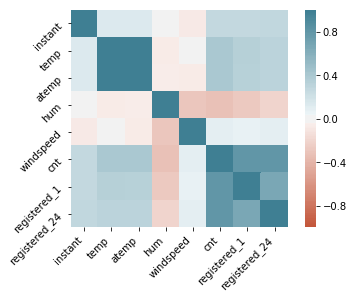

In [32]:
names = ['instant','temp','atemp','hum','windspeed','cnt','registered_1','registered_24']
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(names,
    rotation=45,
    horizontalalignment='right'
)

ax.set_yticklabels(names,
    rotation=45
);

In [33]:
categorical_corr = data[['season', 'yr','mnth','hr','holiday','weekday','workingday','weathersit','precipitation','day']].astype('int64').corr()


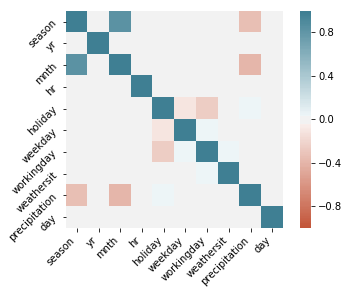

In [34]:
names1 = ['season', 'yr','mnth','hr','holiday','weekday','workingday','weathersit','precipitation','day']
ax = sns.heatmap(
    categorical_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(names1,
    rotation=45,
    horizontalalignment='right'
)

ax.set_yticklabels(names1,
    rotation=45
);

Drop the correlated columns 

In [35]:
del data["workingday"]
del data["atemp"]

In [36]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,weathersit,temp,hum,windspeed,cnt,precipitation,registered_1,registered_24,day
24,25,2011-01-02,1,0,1,0,0,0,2,0.46,0.88,0.2985,17,1,24.0,13.0,2
25,26,2011-01-02,1,0,1,1,0,0,2,0.44,0.94,0.2537,17,1,13.0,32.0,2
26,27,2011-01-02,1,0,1,2,0,0,2,0.42,1.00,0.2836,9,1,16.0,27.0,2
27,28,2011-01-02,1,0,1,3,0,0,2,0.46,0.94,0.1940,6,1,8.0,10.0,2
28,29,2011-01-02,1,0,1,4,0,0,2,0.46,0.94,0.1940,3,1,4.0,1.0,2


### Rescaler


In [37]:
from dask_ml.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(data[['temp','hum','windspeed']])
data[['temp','hum','windspeed']] = transformer.transform(data[['temp','hum','windspeed']])
data.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,weathersit,temp,hum,windspeed,cnt,precipitation,registered_1,registered_24,day
24,25,2011-01-02,1,0,1,0,0,0,2,0.448980,0.88,0.350888,17,1,24.0,13.0,2
25,26,2011-01-02,1,0,1,1,0,0,2,0.428571,0.94,0.298225,17,1,13.0,32.0,2
26,27,2011-01-02,1,0,1,2,0,0,2,0.408163,1.00,0.333373,9,1,16.0,27.0,2
27,28,2011-01-02,1,0,1,3,0,0,2,0.448980,0.94,0.228047,6,1,8.0,10.0,2
28,29,2011-01-02,1,0,1,4,0,0,2,0.448980,0.94,0.228047,3,1,4.0,1.0,2


### One Hot Encoding

We one hot encode categorical columns

In [38]:
data_dummy = dd.get_dummies(data.categorize()).compute()

In [39]:
data_dummy.head()

,instant,dteday,temp,hum,windspeed,cnt,registered_1,registered_24,season_1,season_2,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
24,25,2011-01-02,0.448980,0.88,0.350888,17,24.0,13.0,1,0,...,0,0,0,0,0,0,0,0,0,0
25,26,2011-01-02,0.428571,0.94,0.298225,17,13.0,32.0,1,0,...,0,0,0,0,0,0,0,0,0,0
26,27,2011-01-02,0.408163,1.00,0.333373,9,16.0,27.0,1,0,...,0,0,0,0,0,0,0,0,0,0
27,28,2011-01-02,0.448980,0.94,0.228047,6,8.0,10.0,1,0,...,0,0,0,0,0,0,0,0,0,0
28,29,2011-01-02,0.448980,0.94,0.228047,3,4.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Underrepresented Features

Now we will remove underrepresented features, meaning those that in 99% of the records have a single value

In [40]:
def under_represented_features(df, threshold = 0.99, holdout_df = None):
    under_rep = []
    for column in df:
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
            
    if not under_rep:
        print('No underrepresented features')
    else:
        if TARGET_VARIABLE in under_rep:
            print('The target variable is underrepresented, consider rebalancing')
            under_represented.remove(TARGET_VARIABLE)
        print(' The underrepresented variable is ' + str(under_rep) )
        
under_represented_features(data_dummy)

 The underrepresented variable is ['weathersit_4']


In [41]:
del data_dummy["weathersit_4"]

### Build Final Train Test Set

In [42]:
X_train_final = data_dummy.loc[data_dummy["dteday"] < "2012-10-1"]
del X_train_final["cnt"]
del X_train_final["dteday"]
y_train_final = data_dummy.loc[data_dummy["dteday"] < "2012-10-1","cnt"]

In [43]:
X_test_final = data_dummy.loc[data_dummy["dteday"] >= "2012-10-1"]
del X_test_final["cnt"]
del X_test_final["dteday"]
y_test_final = data_dummy.loc[data_dummy["dteday"] >= "2012-10-1","cnt"]

### Grid Search

In [44]:
from dask.distributed import Client
client = Client()
from sklearn.externals.joblib import parallel_backend
 # Create the parameter grid based on the results of random search 
with parallel_backend('dask'):
    param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10 ],
    'max_features': [2, 3 ],
    'min_samples_leaf': [2, 4 ],
    'min_samples_split': [8, 10 ],
    'n_estimators': [100, 200]
    }

    # Create a based model
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()   
    

In [45]:
from dask_ml.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
grid_search.fit(X_train_final.values, y_train_final.values) 
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [46]:
pred_final = grid_search.best_estimator_.predict(X_test_final.values)
pred_final

array([133.32978823, 113.11248468, 113.64564312, ..., 146.04795733,
       147.31721827, 128.44322941])

I attempted to try Grid Searching for the best parameter for the Random Forest model, however with the best parameter, the model generate very poor prediction thus resulting in low R Squared. Therefore, I will stick with the default random forest model. 

### Build RF Model from the best parameters

In [47]:
with parallel_backend('dask'):
    rf.fit(X_train_final.values, y_train_final.values)
    rf_pref=rf.predict(X_test_final.values)

In [48]:
rf_pref

array([30.6, 31.6, 13.7, ..., 62.7, 60.3, 38.1])

In [56]:
rf_pred_array = da.from_array(rf_pref, chunks=1000)
y_test_array = da.from_array(y_test_final.values, chunks=1000)

from dask_ml.metrics import r2_score as r2
r2(y_test_array, rf_pred_array)

0.9206196914448843

The Random Forest model has generated a much better R Squared of 0.92. This is a huge improvement from the R Squared of the Base Model of 0.76. 

### Build XGBoost Model

In [50]:
X_train_xgb = da.from_array(X_train_final.values,chunks=1000)
y_train_xgb = da.from_array(y_train_final.values,chunks=1000)
X_test_xgb = da.from_array(X_test_final.values,chunks=1000)

In [51]:
from dask_ml.xgboost import XGBRegressor
est = XGBRegressor()
est.fit(X_train_xgb, y_train_xgb)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [52]:
XGB_pred = est.predict(X_test_xgb)
XGB_pred

dask.array<_predict_part, shape=(2168,), dtype=float32, chunksize=(1000,)>

In [53]:
xgb_pred_array = da.from_array(XGB_pred, chunks=1000)
r2(y_test_array, xgb_pred_array)

0.9040039912316538

The XGBoost model did well, generating a slightly lower R Squared than the Random Forest model. Thus I will settle with the Random Forest model. 